### 1. Import packages <a class="anchor" id="1"></a>

In [15]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import random 
import os
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import multiprocessing
import torch.nn.functional as F
import numpy as np 
import pandas as pd 

#%matplotlib inline

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
device

'cpu'

#### 1.1 Seed everything <a class="anchor" id="11"></a>

In [18]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#### 1.2 Set cuDNN and PyTorch to be deterministic <a class="anchor" id="12"></a>

In [19]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

#### 1.3 Pick an item to model <a class="anchor" id="13"></a>

### 2. LSTM model for univariate time series <a class="anchor" id="2"></a>

#### 2.1 Define dataset <a class="anchor" id="21"></a>

In [20]:
import pandas as pd

# Set the directory path to where your CSV files are located
INPUT_DIR_PATH = '' # or the appropriate path

def read_data():
    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_evaluation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_evaluation.csv')
    print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation_df.shape[0], sales_train_evaluation_df.shape[1]))

    return calendar_df, sales_train_evaluation_df

# Read the data
calendar_df, sales_train_evaluation_df = read_data()


Calendar has 1969 rows and 14 columns
Sales train evaluation has 30490 rows and 1947 columns


In [21]:
import pandas as pd

# Set the directory path to where your CSV files are located
INPUT_DIR_PATH = '' # or the appropriate path

def read_data():
    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_evaluation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_evaluation.csv')
    print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation_df.shape[0], sales_train_evaluation_df.shape[1]))

    return calendar_df, sales_train_evaluation_df

# Read the data
calendar_df, sales_train_evaluation_df = read_data()

# Define the item to model
item_to_model = 'HOBBIES_1_004_CA_1_evaluation'

# Filter the sales data for the item to model
sales_train_evaluation_df = sales_train_evaluation_df[sales_train_evaluation_df.id == item_to_model]

# Find all columns that have a day notation 'd_'
d_cols = [col for col in sales_train_evaluation_df.columns if col.startswith('d_')]

# Transpose the dataframe and merge with the calendar data
ste_t = sales_train_evaluation_df[['id'] + d_cols].set_index('id').T
ste_td = ste_t.merge(calendar_df[['date','d']].set_index('d'), left_index=True, right_index=True, validate='1:1').set_index('date')

# Print the shape of the resulting dataframe
print(ste_td.shape)


Calendar has 1969 rows and 14 columns
Sales train evaluation has 30490 rows and 1947 columns
(1941, 1)


In [22]:
# normalize the series to be in the range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
ste_normalized = scaler.fit_transform(ste_td)

In [23]:
# train / valid / test split
tr_arr = ste_normalized[:1717,:]
va_arr = ste_normalized[1717:1913,:]
te_arr = ste_normalized[1913:,:]

print(tr_arr.shape, va_arr.shape, te_arr.shape)

(1717, 1) (196, 1) (28, 1)


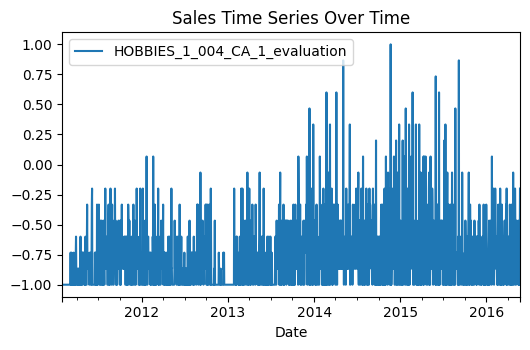

In [24]:
# make a plot to visualize the time series
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(540/my_dpi, 360/my_dpi), dpi=my_dpi)
y = pd.DataFrame(ste_normalized)
y = pd.DataFrame(y).set_index(ste_td.index)
y.index = pd.to_datetime(y.index)
y.columns = [item_to_model]
y.plot(color='C0', ax = ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.legend(False)
plt.title(label = 'Sales Time Series Over Time',fontsize = 12)
plt.xlabel(xlabel = 'Date',fontsize = 10)
plt.tight_layout()
plt.savefig(f'time_series_item.png', dpi = my_dpi);

In [25]:
class M5_Univariate_Dataset(Dataset):
    def __init__(self, df, seq_length):
        self.df = df
        self.seq_length = seq_length
        self.total_length = df.shape[0] - seq_length 
    
    def __len__(self):
        return self.total_length
    
    def __getitem__(self, index):
        if index < self.total_length:
            sequence = self.df[index: index + self.seq_length]
            target = self.df[index + self.seq_length]
            return torch.tensor(sequence, dtype=torch.float32), \
                    torch.tensor(target, dtype=torch.float32)


In [29]:
BATCH_SIZE = 32
SEQ_LENGTH = 28
tr_ds = M5_Univariate_Dataset(tr_arr, SEQ_LENGTH)
va_ds = M5_Univariate_Dataset(va_arr, SEQ_LENGTH)

num_workers = multiprocessing.cpu_count()
print(len(tr_dl), len(va_dl))

53 6


In [28]:
tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True, num_workers=0)
va_dl = DataLoader(va_ds, batch_size=32, shuffle=False, num_workers=0)

# Checking the training dataset
print('Training Set:\n')
for history, target in tr_dl:  
    print('batch dimensions:', history.size())
    print('label dimensions:', target.size())
    print(target[:3])
    break
    
# Checking the validation dataset
print('\nValidation Set:')
for history, target in va_dl:  
    print('batch dimensions:', history.size())
    print('target dimensions:', target.size())
    print(target[:3])
    break

Training Set:

batch dimensions: torch.Size([32, 28, 1])
label dimensions: torch.Size([32, 1])
tensor([[-0.8667],
        [-1.0000],
        [-0.8667]])

Validation Set:
batch dimensions: torch.Size([32, 28, 1])
target dimensions: torch.Size([32, 1])
tensor([[-1.0000],
        [-1.0000],
        [-0.4667]])


#### 2.2 Define LSTM model <a class="anchor" id="22"></a>

In [18]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # out: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x)
        # take the out at the last time step
        # out: (batch_size, hidden_size)
        out = out[:, -1]
        # pred: (batch_size, 1)
        pred = self.fc(out)
        # output: batch_size
        return pred.squeeze()

In [19]:
num_epochs = 10
learning_rate = 1e-4
input_size = 1
hidden_size = 64
num_layers = 1

In [20]:
#####Init the Model #######################
lstm = LSTM(input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
loss_fn = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-6)

#### 2.3 Train model <a class="anchor" id="23"></a>

In [21]:
def train(model, num_epochs, tr_dl, va_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    
    model.to(device)
    start_time = time.time()
    for epoch in range(num_epochs): 
        lstm.train()
        avg_loss = 0
        for i, (history, target) in enumerate(tr_dl):
            # forward
            outputs = lstm(history.to(device))
            loss = loss_fn(outputs, target.to(device))
            # backward
            optimizer.zero_grad()
            loss.backward()
            # update
            optimizer.step()
            # log
            avg_loss += loss.item() / len(tr_dl)

        lstm.eval()
        avg_val_loss = 0
        with torch.no_grad():
            for history, target in va_dl:
                outputs = lstm(history.to(device))
                loss = loss_fn(outputs, target.to(device))
                avg_val_loss += loss.item() / len(va_dl)

        elapsed_time = time.time() - start_time
        
        loss_hist_train[epoch] = avg_loss
        loss_hist_valid[epoch] = avg_val_loss
        
        if epoch % 10 == 0:
            print(
                    f"Epoch {epoch:02d}/{num_epochs:02d} \t t={elapsed_time:.0f}s \t"
                    f"loss={avg_loss:.3f} \t",
                    f"val_loss={avg_val_loss:.3f}"
                )
    return loss_hist_train, loss_hist_valid

history = train(lstm, num_epochs, tr_dl, va_dl)

Epoch 00/10 	 t=1s 	loss=0.510 	 val_loss=0.396


In [22]:
# save training history to file
l1 = history[0]
l2 = history[1]
df = pd.DataFrame(zip(l1,l2), columns =['Train_mse', 'Validation_mse'])
df.to_csv('history_uni.csv')

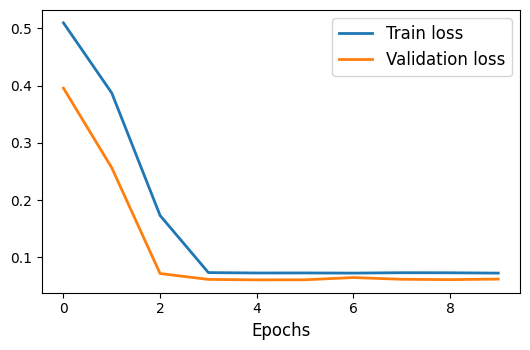

In [23]:
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(540/my_dpi, 360/my_dpi), dpi=my_dpi)
ax.plot(history[0], lw=2)
ax.plot(history[1], lw=2)
ax.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)
plt.tight_layout()
plt.savefig(f'model_train_history_uni.png', dpi = my_dpi);

#### 2.4 Forecasting several steps <a class="anchor" id="24"></a>

In [24]:
PREDICTION_LENGTH = 28
va_last_seq = va_arr[-SEQ_LENGTH:]
x = torch.from_numpy(va_last_seq).float()
x = x.to(device).unsqueeze(0)
y_preds = []
for step_ahead in range(PREDICTION_LENGTH):
    y_pred_one = lstm(x)
    y_preds.append(y_pred_one.item())
    x = torch.cat([x[:,1:,:], y_pred_one.reshape(1,1,1)], axis = 1)

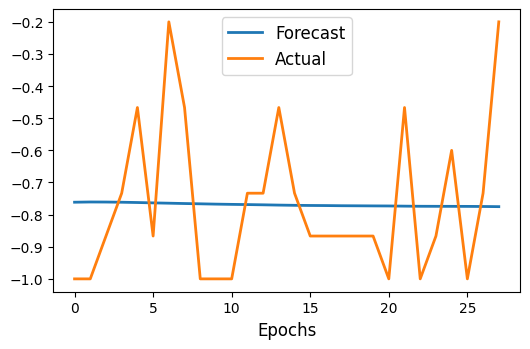

In [26]:
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(540/my_dpi, 360/my_dpi), dpi=my_dpi)
ax.plot(y_preds, lw=2)
ax.plot(te_arr, lw=2)
ax.legend(['Forecast', 'Actual'], fontsize=12)
ax.set_xlabel('Epochs', size=12)
plt.tight_layout()
plt.savefig(f'forecast_uni.png', dpi = my_dpi);

In [28]:
print('MSE on the test period =', mean_squared_error(te_arr[:,0], y_preds))

MSE on the test period = 0.05552173067746471


### 3. LSTM model for multivariate time series <a class="anchor" id="3"></a>

#### 3.1 Define Dataset <a class="anchor" id="31"></a>

In [29]:
# add the day of week of yesterday as a new series
ste_t = sales_train_evaluation_df[['id']+ d_cols].set_index('id').T
ste_td = ste_t.merge(calendar_df[['date','d']].set_index('d'),
           left_index = True, right_index=True, validate='1:1').set_index('date')
ste_td = ste_td.reset_index()
ste_td = ste_td.assign(date = pd.to_datetime(ste_td.date))
ste_td = ste_td.assign(tmr = ste_td.date.shift(-1))
ste_td.loc[ste_td.shape[0] - 1,'tmr'] = ste_td.loc[ste_td.shape[0] - 1,'date']  + pd.DateOffset(1)
ste_td = ste_td.assign(tmr_dow = ste_td.tmr.dt.day_name().astype('category'))
ste_td.tail(10)

,date,HOBBIES_1_004_CA_1_evaluation,tmr,tmr_dow
1931,2016-05-13,1,2016-05-14,Saturday
1932,2016-05-14,1,2016-05-15,Sunday
1933,2016-05-15,0,2016-05-16,Monday
1934,2016-05-16,4,2016-05-17,Tuesday
1935,2016-05-17,0,2016-05-18,Wednesday
1936,2016-05-18,1,2016-05-19,Thursday
1937,2016-05-19,3,2016-05-20,Friday
1938,2016-05-20,0,2016-05-21,Saturday
1939,2016-05-21,2,2016-05-22,Sunday
1940,2016-05-22,6,2016-05-23,Monday


In [30]:
unique_levels = len(set(ste_td['tmr_dow']))
print('tmr_dow', 'unique levels =', unique_levels)
print(ste_td['tmr_dow'].value_counts(dropna = False))
dow_encoded = F.one_hot((torch.from_numpy(ste_td['tmr_dow'].cat.codes.values) % unique_levels).long(), num_classes = unique_levels)
y = torch.from_numpy(ste_td['HOBBIES_1_004_CA_1_evaluation'].values).float()
data = torch.cat([y.reshape(-1,1), dow_encoded], axis = 1)

tmr_dow unique levels = 7
tmr_dow
Monday       278
Sunday       278
Friday       277
Saturday     277
Thursday     277
Tuesday      277
Wednesday    277
Name: count, dtype: int64


In [31]:
# normalize to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
ste_normalized = scaler.fit_transform(data)

In [32]:
# train / valid / test split

tr_arr = ste_normalized[:1717,:]
va_arr = ste_normalized[1717:1913,:]
te_arr = ste_normalized[1913:,:]

print(tr_arr.shape, va_arr.shape, te_arr.shape)

(1717, 8) (196, 8) (28, 8)


In [34]:
class M5_Multivariate_Dataset(Dataset):
    def __init__(self, df, seq_length):
        self.df = df
        self.seq_length = seq_length
        self.total_length = len(df[:,0]) - seq_length 
    
    def __len__(self):
        return self.total_length
    
    def __getitem__(self, index):
        if index < self.total_length:
            sequence = self.df[index: index + self.seq_length,:]
            target = self.df[index + self.seq_length,0]
            return torch.tensor(sequence, dtype=torch.float32), \
                    torch.tensor(target, dtype=torch.float32)

In [35]:
BATCH_SIZE = 32
SEQ_LENGTH = 28
tr_ds = M5_Multivariate_Dataset(tr_arr, SEQ_LENGTH)
va_ds = M5_Multivariate_Dataset(va_arr, SEQ_LENGTH)

num_workers = multiprocessing.cpu_count()
print(len(tr_dl), len(va_dl))

53 6


In [36]:
tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True, num_workers=0)
va_dl = DataLoader(va_ds, batch_size=32, shuffle=False, num_workers=0)
# Checking the dataset
print('Training Set:\n')
for history, target in tr_dl:  
    print('batch dimensions:', history.size())
    print('label dimensions:', target.size())
    print(target[:3])
    break
    
# Checking the dataset
print('\nValidation Set:')
for history, target in va_dl:  
    print('batch dimensions:', history.size())
    print('target dimensions:', target.size())
    print(target[:3])
    break

Training Set:

batch dimensions: torch.Size([32, 28, 8])
label dimensions: torch.Size([32])
tensor([-0.4667, -0.8667, -0.3333])

Validation Set:
batch dimensions: torch.Size([32, 28, 8])
target dimensions: torch.Size([32])
tensor([-1.0000, -1.0000, -0.4667])


#### 3.2 Define LSTM model <a class="anchor" id="32"></a>

In [53]:
#####  Parameters  ######################
num_epochs = 100
learning_rate = 3e-4
input_size = tr_arr.shape[1]
hidden_size = 64
num_layers = 1

In [38]:
##### Init the Model #######################
lstm = LSTM(input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
loss_fn = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-6)

#### 3.3 Train model <a class="anchor" id="33"></a>

In [54]:
history = train(lstm, num_epochs, tr_dl, va_dl)

Epoch 00/100 	 t=1s 	loss=0.057 	 val_loss=0.053
Epoch 10/100 	 t=6s 	loss=0.056 	 val_loss=0.060
Epoch 20/100 	 t=12s 	loss=0.056 	 val_loss=0.053
Epoch 30/100 	 t=17s 	loss=0.056 	 val_loss=0.053
Epoch 40/100 	 t=25s 	loss=0.055 	 val_loss=0.053
Epoch 50/100 	 t=31s 	loss=0.056 	 val_loss=0.052
Epoch 60/100 	 t=36s 	loss=0.055 	 val_loss=0.052
Epoch 70/100 	 t=43s 	loss=0.057 	 val_loss=0.052
Epoch 80/100 	 t=49s 	loss=0.055 	 val_loss=0.057
Epoch 90/100 	 t=56s 	loss=0.055 	 val_loss=0.055


In [55]:
# write training history to file
l1 = history[0]
l2 = history[1]
df = pd.DataFrame(zip(l1,l2), columns =['Train_mse', 'Validation_mse'])
df.to_csv('history_multi.csv')


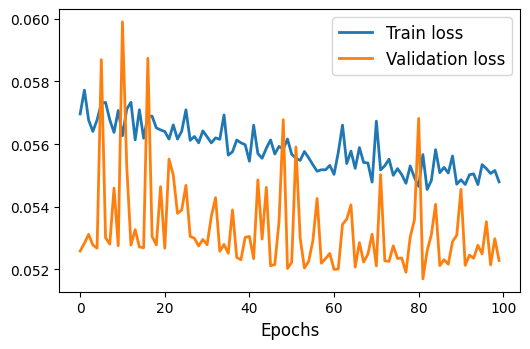

In [56]:
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(540/my_dpi, 360/my_dpi), dpi=my_dpi)
ax.plot(history[0], lw=2)
ax.plot(history[1], lw=2)
ax.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)
plt.tight_layout()
plt.savefig(f'model_train_history_multi.png', dpi = my_dpi);

#### 3.4 Forecasting several steps <a class="anchor" id="34"></a>

In [57]:
PREDICTION_LENGTH = 28

va_last_seq = va_arr[-SEQ_LENGTH:]
x = torch.from_numpy(va_last_seq).float()
x = x.to(device).unsqueeze(0)
y_preds = []
for step_ahead in range(PREDICTION_LENGTH):
    y_pred_one = lstm(x)
    y_preds.append(y_pred_one.item())
    y_pred_multi = torch.from_numpy(te_arr[step_ahead,1:]).float()
    
    y_pred_multi = torch.cat([y_pred_multi, y_pred_one.reshape(1).cpu().detach()], axis = 0)
    x = torch.cat([x[:,1:,:], y_pred_multi.unsqueeze(0).unsqueeze(0).to(device)], axis = 1)

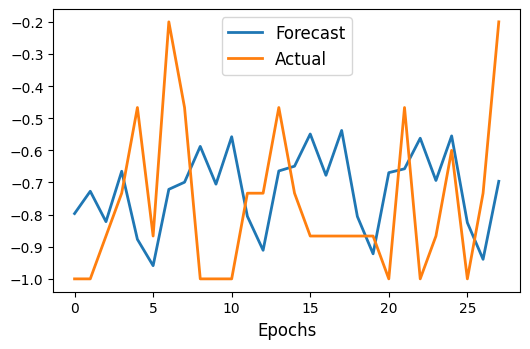

In [58]:
my_dpi = 100
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(540/my_dpi, 360/my_dpi), dpi=my_dpi)
ax.plot(y_preds, lw=2)
ax.plot(te_arr[:,0], lw=2)
ax.legend(['Forecast', 'Actual'], fontsize=12)
ax.set_xlabel('Epochs', size=12)
plt.tight_layout()
plt.savefig(f'forecast_multi.png', dpi = my_dpi);

In [60]:
print('MSE on the test period =', mean_squared_error(te_arr[:,0], y_preds))

MSE on the test period = 0.07501111989259633


#### Define RNN Model

In [33]:
# add the day of week of yesterday as a new series
ste_t = sales_train_evaluation_df[['id']+ d_cols].set_index('id').T
ste_td = ste_t.merge(calendar_df[['date','d']].set_index('d'),
           left_index = True, right_index=True, validate='1:1').set_index('date')
ste_td = ste_td.reset_index()
ste_td = ste_td.assign(date = pd.to_datetime(ste_td.date))
ste_td = ste_td.assign(tmr = ste_td.date.shift(-1))
ste_td.loc[ste_td.shape[0] - 1,'tmr'] = ste_td.loc[ste_td.shape[0] - 1,'date']  + pd.DateOffset(1)
ste_td = ste_td.assign(tmr_dow = ste_td.tmr.dt.day_name().astype('category'))
ste_td.tail(10)

,date,HOBBIES_1_004_CA_1_evaluation,tmr,tmr_dow
1931,2016-05-13,1,2016-05-14,Saturday
1932,2016-05-14,1,2016-05-15,Sunday
1933,2016-05-15,0,2016-05-16,Monday
1934,2016-05-16,4,2016-05-17,Tuesday
1935,2016-05-17,0,2016-05-18,Wednesday
1936,2016-05-18,1,2016-05-19,Thursday
1937,2016-05-19,3,2016-05-20,Friday
1938,2016-05-20,0,2016-05-21,Saturday
1939,2016-05-21,2,2016-05-22,Sunday
1940,2016-05-22,6,2016-05-23,Monday


In [35]:
unique_levels = len(set(ste_td['tmr_dow']))
print('tmr_dow', 'unique levels =', unique_levels)
print(ste_td['tmr_dow'].value_counts(dropna = False))
dow_encoded = F.one_hot((torch.from_numpy(ste_td['tmr_dow'].cat.codes.values) % unique_levels).long(), num_classes = unique_levels)
y = torch.from_numpy(ste_td['HOBBIES_1_004_CA_1_evaluation'].values).float()
data = torch.cat([y.reshape(-1,1), dow_encoded], axis = 1)

tmr_dow unique levels = 7
tmr_dow
Monday       278
Sunday       278
Friday       277
Saturday     277
Thursday     277
Tuesday      277
Wednesday    277
Name: count, dtype: int64


In [36]:
# normalize to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
ste_normalized = scaler.fit_transform(data)

In [38]:
class M5_Multivariate_Dataset(Dataset):
    def __init__(self, df, seq_length):
        self.df = df
        self.seq_length = seq_length
        self.total_length = len(df[:,0]) - seq_length 
    
    def __len__(self):
        return self.total_length
    
    def __getitem__(self, index):
        if index < self.total_length:
            sequence = self.df[index: index + self.seq_length,:]
            target = self.df[index + self.seq_length,0]
            return torch.tensor(sequence, dtype=torch.float32), \
                    torch.tensor(target, dtype=torch.float32)

In [37]:
# train / valid / test split

tr_arr = ste_normalized[:1717,:]
va_arr = ste_normalized[1717:1913,:]
te_arr = ste_normalized[1913:,:]

print(tr_arr.shape, va_arr.shape, te_arr.shape)

(1717, 8) (196, 8) (28, 8)


In [39]:
BATCH_SIZE = 32
SEQ_LENGTH = 28
tr_ds = M5_Multivariate_Dataset(tr_arr, SEQ_LENGTH)
va_ds = M5_Multivariate_Dataset(va_arr, SEQ_LENGTH)

num_workers = multiprocessing.cpu_count()
print(len(tr_dl), len(va_dl))

53 6


In [40]:
tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True, num_workers=0)
va_dl = DataLoader(va_ds, batch_size=32, shuffle=False, num_workers=0)
# Checking the dataset
print('Training Set:\n')
for history, target in tr_dl:  
    print('batch dimensions:', history.size())
    print('label dimensions:', target.size())
    print(target[:3])
    break
    
# Checking the dataset
print('\nValidation Set:')
for history, target in va_dl:  
    print('batch dimensions:', history.size())
    print('target dimensions:', target.size())
    print(target[:3])
    break

Training Set:

batch dimensions: torch.Size([32, 28, 8])
label dimensions: torch.Size([32])
tensor([-1.0000, -0.6000, -0.8667])

Validation Set:
batch dimensions: torch.Size([32, 28, 8])
target dimensions: torch.Size([32])
tensor([-1.0000, -1.0000, -0.4667])


In [30]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.lstm = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # out: (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x)
        # take the out at the last time step
        # out: (batch_size, hidden_size)
        out = out[:, -1]
        # pred: (batch_size, 1)
        pred = self.fc(out)
        # output: batch_size
        return pred.squeeze()

In [41]:
num_epochs = 100
learning_rate = 3e-4
input_size = tr_arr.shape[1]
hidden_size = 64
num_layers = 1

In [42]:
##### Init the Model #######################
rnn = RNN(input_size, hidden_size, num_layers)
rnn.to(device)

##### Set Criterion Optimzer and scheduler ####################
loss_fn = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=1e-6)

In [46]:
def train_rnn(model, num_epochs, tr_dl, va_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    
    model.to(device)
    start_time = time.time()
    for epoch in range(num_epochs): 
        rnn.train()
        avg_loss = 0
        for i, (history, target) in enumerate(tr_dl):
            # forward
            outputs = lstm(history.to(device))
            loss = loss_fn(outputs, target.to(device))
            # backward
            optimizer.zero_grad()
            loss.backward()
            # update
            optimizer.step()
            # log
            avg_loss += loss.item() / len(tr_dl)

        rnn.eval()
        avg_val_loss = 0
        with torch.no_grad():
            for history, target in va_dl:
                outputs = rnn(history.to(device))
                loss = loss_fn(outputs, target.to(device))
                avg_val_loss += loss.item() / len(va_dl)

        elapsed_time = time.time() - start_time
        
        loss_hist_train[epoch] = avg_loss
        loss_hist_valid[epoch] = avg_val_loss
        
        if epoch % 10 == 0:
            print(
                    f"Epoch {epoch:02d}/{num_epochs:02d} \t t={elapsed_time:.0f}s \t"
                    f"loss={avg_loss:.3f} \t",
                    f"val_loss={avg_val_loss:.3f}"
                )
    return loss_hist_train, loss_hist_valid

history = train_rnn(rnn, num_epochs, tr_dl, va_dl)

AttributeError: 'RNN' object has no attribute 'rnn'

In [44]:
history = train(rnn, num_epochs, tr_dl, va_dl)

NameError: name 'train' is not defined